# Toy model to test how smoothing kernel transforms shot noise

In [1]:
import numpy as np
import math
import scipy.stats
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from pypower import CatalogMesh
from densitysplit.edgeworth_development import *

### Create cubic box with uniformly distributed random points and apply Gaussian kernel

In [2]:
seed = 0
offset = -50
boxsize = 100
size = 50000

In [3]:
def gaussian_kernel(positions, sigma):
    r = np.sum(positions**2, axis=0)**0.5
    kernel = np.exp(-r**2/(2. * sigma**2)) / np.sqrt(2*np.pi)
    return kernel

def top_hat_kernel(positions, size):
    r = np.sum(positions**2, axis=0)**0.5
    kernel = np.array([r<size])
    return kernel

def cic(positions, size):
    abs_positions = np.abs(positions)/size
    area = np.logical_and(np.logical_and(abs_positions[0]<1., abs_positions[1]<1.), abs_positions[2]<1.)
    kernel = np.array([(1 - abs_positions[0][area])*(1 - abs_positions[1][area])*(1 - abs_positions[2][area])])
    return kernel

def tsc_1D(positions, size):
    abs_positions = np.abs(positions)/size
    area1 = abs_positions < 3./2
    area2 = abs_positions < 1./2
    kernel1 = (3./2 - abs_positions**2)**2 / 2.
    kernel2 = 3./4 - abs_positions**2
    kernel = np.where(area1, kernel1, np.full_like(area1, 0))
    return np.where(area2, kernel2, kernel)

def tsc(positions, size):
    kernel_x = tsc_1D(positions[0], size)
    kernel_y = tsc_1D(positions[1], size)
    kernel_z = tsc_1D(positions[2], size)
    return kernel_x * kernel_y * kernel_z

def run_exp(param, seed=0):
    # Fill cubic box with random points
    rng = np.random.RandomState(seed=seed)
    positions = np.array([o + rng.uniform(0., 1., size)*b for o, b in zip((offset,)*3, (boxsize,)*3)]) 
    # Apply kernel
    kernel = tsc(positions, param)
    counts = np.sum(kernel)
    return counts

### Run the experiment N times

In [4]:
N = 1000
result = list()
sigma = 5

for i in range(N):
    counts = run_exp(param=sigma, seed=i)
    result.append(counts)

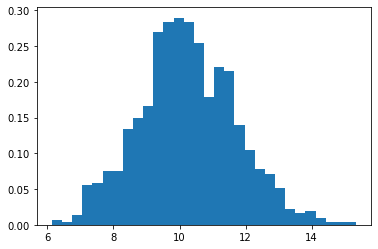

In [5]:
plt.hist(result, bins=30, density=True)
plt.show()

In [6]:
nbar = size / boxsize**3
nbar

0.05

### Compare with theoretical model

In [7]:
def cumulant_gaussian_kernel(nbar, sigma, p):
    res = 2. * nbar / (p**(3/2) * (1 * np.pi)**((p-3)/2.) * sigma**(p-3))
    return res

def cumulant_cic(nbar, h, p):
    res = nbar * (2 * h / (p+1))**3
    return res

def cumulant_tsc(nbar, h, p):
    if p == 1:
        res = 283./240
    if p == 2:
        res = 112019./161280
    if p == 3:
        res = 36676089./82001920
    if p == 4:
        res = 120026817301./401481400320
    return (res * h)**3 * nbar

In [8]:
#def he3(x):
#    return x**3 - 3 * x

#def he4(x):
#    return x**4 - 6 * x**2 + 3

#def pdf_from_cumulants(x, cumulants):
#    mu, sigma, k3, k4 = cumulants
#    y = (x - mu) / sigma
#    return np.exp(- y**2/2.) * (1 + k3/(6*sigma**3) * he3(y) + k4/(24*sigma**4) * he4(y)) / (np.sqrt(2*np.pi) * sigma)

In [9]:
cmap = plt.get_cmap('plasma')

[10.247209110966438, 2.09417777965406]
[10.247209110966438, 2.09417777965406, 0.5591869246349529]
[10.247209110966438, 2.09417777965406, 0.5591869246349529, 0.16700081759722388]


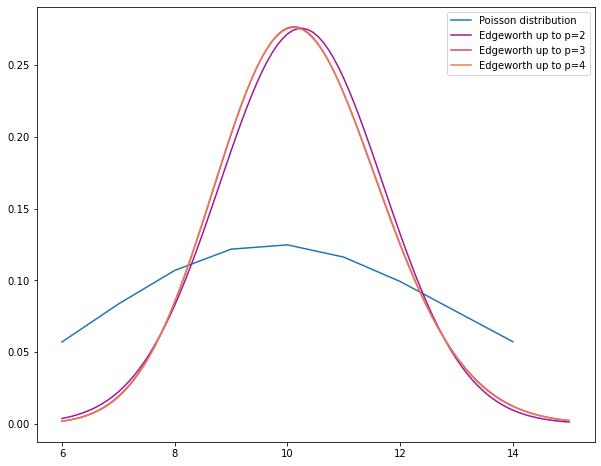

In [11]:
#cumulants = [cumulant_gaussian_kernel(sigma, i+1) for i in range(4)]
#cumulants = [nbar, nbar, nbar, nbar]

plt.rcParams["figure.figsize"] = (10, 8)

x = np.linspace(6, 15, 100)
x_int = np.arange(6, 15)
#plt.plot(x, pdf_from_cumulants(x, cumulants))
#plt.plot(x_int, scipy.stats.poisson.pmf(x_int, nbar * (4./3. * np.pi * (sigma)**3)), label='Poisson distribution')
#plt.plot(x_int, scipy.stats.poisson.pmf(x_int, nbar * sigma**3), label='Poisson distribution')
plt.plot(x_int, scipy.stats.poisson.pmf(x_int, nbar * (sigma*283./240)**3), label='Poisson distribution')

for p in range(2, 5):
    #cumulants = [nbar * (4./3. * np.pi * (sigma)**3) for i in range(p)]
    cumulants = [cumulant_tsc(nbar, sigma, i+1) for i in range(p)]
    print(cumulants)
    edgew = ExpandedNormal(cum=cumulants)
    plt.plot(x, edgew.pdf(x), label='Edgeworth up to p={}'.format(p), color=cmap(p/6))
    
plt.legend()
plt.show()

In [12]:
cumulants = [cumulant_tsc(nbar, sigma, i+1) for i in range(4)]
cumulants

[10.247209110966438, 2.09417777965406, 0.5591869246349529, 0.16700081759722388]

In [13]:
nbar * sigma**3

6.25

In [16]:
gauss = ExpandedNormal(cum=[cumulant_tsc(nbar, sigma, i+1) for i in range(2)])

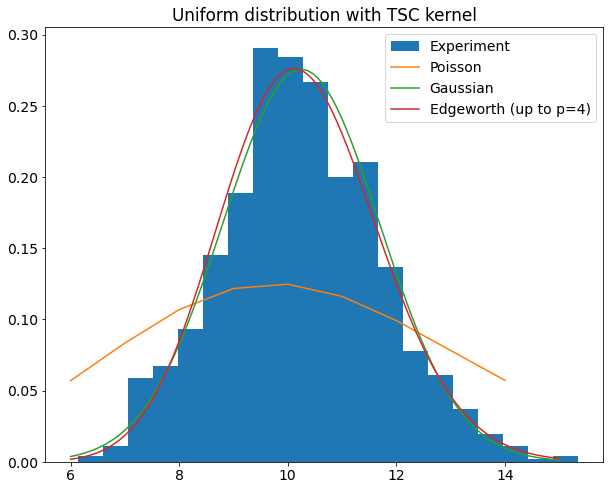

In [21]:
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

plt.hist(result, bins=20, density=True, label='Experiment')
plt.plot(x_int, scipy.stats.poisson.pmf(x_int, nbar * (sigma*283./240)**3), label='Poisson')
plt.plot(x, gauss.pdf(x), label='Gaussian')
plt.plot(x, edgew.pdf(x), label='Edgeworth (up to p=4)')
plt.legend()
plt.title('Uniform distribution with TSC kernel')
plt.show()